In [1]:
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

# helpers.py file
from helpers import *  

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso

# Ensemble models
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor

# model selection
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn.inspection import plot_partial_dependence 

In [3]:
# Load df for modeling
df = pd.read_csv('final_train_df.csv')
test_df = pd.read_csv('final_test_df.csv')

## Train/Test split

In [4]:
# Define X and y
X=  df.drop(columns=['count'])
# Use log(1+y) as new y label since the error metric is RMSLE
y = np.log1p(df['count'])

# Train,Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size = 0.2, 
                                       random_state = 1)

# Linear regression models 

## Simple Linear regression (baseline)

In [124]:
# Initialize logistic regression model
LR = LinearRegression()

# Train the model
LR.fit(X = X_train,y = y_train)

# Make predictions
y_pred = LR.predict(X=X_test)

# RMLSE (Since y variables are already in log(1+y) format, RMSE from log format is RMSLE for y)
mean_squared_error(y_test, y_pred)**0.5

0.5878011632342414

## Linear regression with Ridge Regularization

In [21]:
LR_R = Ridge()

alpha = np.logspace(-2,6, 20)

LR_R_params = {'max_iter':[100,1000,10000],
               'alpha':alpha,
               }

LR_R_grid = GridSearchCV(LR_R,
                          LR_R_params,                          
                          scoring='neg_mean_squared_error',
                          cv=5)


LR_R_grid.fit(X_train, y_train)
print (LR_R_grid.best_params_)

y_pred = LR_R_grid.predict(X_test)
print ("RMSLE Value For Ridge Regression: ", mean_squared_error(y_test, y_pred)**0.5  )

{'alpha': 0.18329807108324356, 'max_iter': 100}
RMSLE Value For Ridge Regression:  0.5878209433739295


## Linear regression with Lasso

In [31]:
LR_L = Lasso()

alpha = np.logspace(-3,2, 20)

LR_L_params = {'max_iter':[50,100,1000],
               'alpha':alpha,
               'normalize':[True, False]}

LR_L_grid = GridSearchCV(LR_L,
                         LR_L_params,
                         scoring = 'neg_mean_squared_error',
                         cv=5)


LR_L_grid.fit(X_train,y_train)
print (LR_L_grid.best_params_)

y_pred = LR_L_grid.predict(X_test)
print ("RMSLE Value For Lasso Regression: ",mean_squared_error(y_test, y_pred)**0.5)

{'alpha': 0.001, 'max_iter': 50, 'normalize': False}
RMSLE Value For Lasso Regression:  0.5896477470529488


## Ensemble Models 

In [11]:
# Start with default settings
RF = RandomForestRegressor()
GBR = GradientBoostingRegressor()

In [153]:
# k fold cross validation on default models
k = 10
cross_val(RF, X_train, y_train, k) 
cross_val(GBR, X_train, y_train, k) 

RandomForestRegressor     Train CV | MSE: 0.108 | R2: 0.947
GradientBoostingRegressor Train CV | MSE: 0.225 | R2: 0.888
AdaBoostRegressor         Train CV | MSE: 1.100 | R2: 0.443


## Hyperparameter tuning through GridSearch

In [154]:
random_forest_grid = {'n_estimators': [100,200,300,400,500],
                      'max_depth': [None, 10, 30, 50],
                      'min_samples_split': [2, 4, 6],
                      'min_samples_leaf': [1, 2, 4],
                      'max_features': ['auto','log2', None],
                      'bootstrap': [True],
                      'random_state': [1]}

rf_best_params, rf_best_model = gridsearch_with_output(RandomForestRegressor(), 
                                                       random_forest_grid, 
                                                       X_train, y_train)

print("\nComparing model with gridsearch params to initial model on Test set.")
RF.fit(X_train, y_train)
display_default_and_gsearch_model_results(RF, rf_best_model, X_test, y_test)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 51.3min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 59.1min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
n_estimators         | 500      | [100, 200, 300, 400, 500]
max_depth            | None     | [None, 10, 30, 50]
min_samples_split    | 2        | [2, 4, 6]
min_samples_leaf     | 1        | [1, 2, 4]
max_features         | auto     | ['auto', 'log2', None]
bootstrap            | True     | [True]
random_state         | 1        | [1]

Comparing model with gridsearch params to initial model on Test set.
Results for RandomForest
Gridsearched model mse: 0.111 | r2: 0.946
     Default model mse: 0.113 | r2: 0.944


In [10]:
gradient_boosting_grid = {'learning_rate': [0.01, 0.005],
                          'n_estimators': [5000,10000],
                          'min_samples_leaf': [20,24,28],    # To prevent overfitting
                          'max_depth': [6,8,10],
                          'max_features': [1.0, 0.3, 0.1],                          
                          'random_state': [1]}

gdbr_best_params, gdbr_best_model = gridsearch_with_output(GradientBoostingRegressor(), 
                                                           gradient_boosting_grid, 
                                                           X_train, y_train)
print("\nComparing model with gridsearch params to initial model on Test set.")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 106.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 134.4min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
learning_rate        | 0.01     | [0.01, 0.005]
n_estimators         | 10000    | [5000, 10000]
min_samples_leaf     | 20       | [20, 24, 28]
max_depth            | 8        | [6, 8, 10]
max_features         | 0.1      | [1.0, 0.3, 0.1]
random_state         | 1        | [1]

Comparing model with gridsearch params to initial model on Test set.


NameError: name 'GBR' is not defined

In [12]:
GBR.fit(X_train, y_train)
display_default_and_gsearch_model_results(GBR, gdbr_best_model, X_test, y_test)

Results for GradientBoosting
Gridsearched model rmlse: 0.288)
     Default model rmsle: 0.483


In [33]:
gdbr_best_model = GradientBoostingRegressor(learning_rate=0.005, max_depth=6, min_samples_leaf = 24, n_estimators = 10000, random_state=1)

In [39]:
gdbr_best_model.fit(X_train,y_train)
y_pred = gdbr_best_model.predict(X_test)
print ("RMSLE Value For best GDBR: ",mean_squared_error(y_test, y_pred)**0.5)

RMSLE Value For best GDBR:  0.2964777296207734


In [40]:
rf_best_model.fit(X_train,y_train)
y_pred = rf_best_model.predict(X_test)
print ("RMSLE Value For best RF: ",mean_squared_error(y_test, y_pred)**0.5)

RMSLE Value For best RF:  0.33247541585131374


## Plot showing RMSE for Linear, Ridge, Lasso, RF, GB

Text(0.5, 1.0, 'RMSLE value for different models')

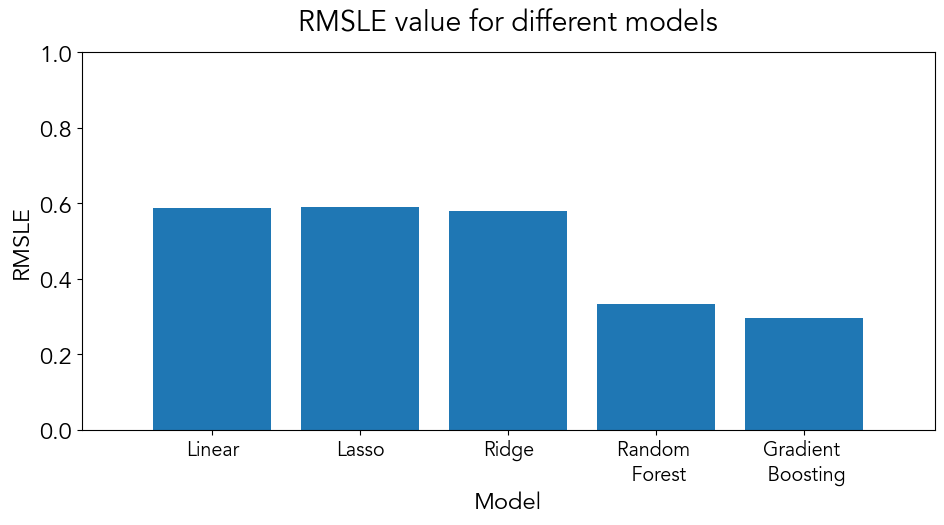

In [54]:
fig, ax = plt.subplots(figsize=(11,5))
models = ['Linear', "Lasso", "Ridge", "Random \n Forest", "Gradient \n Boosting"]
RMSLE = [0.5878, 0.5896,0.578828, 0.3324, 0.2964]

plt.bar(models, RMSLE)
plt.ylim(0,1)
plt.ylabel('RMSLE')
plt.xlabel('Model')
plt.title('RMSLE value for different models')

## Pickling models

In [35]:
# save the model to disk
filename = 'best_gdbr_model.sav'
pickle.dump(gdbr_best_model, open(filename, 'wb'))

In [160]:
filename = 'best_rf_model.sav'
pickle.dump(rf_best_model, open(filename, 'wb'))

In [37]:
# load a model from disk
filename = 'best_gdbr_model.sav'
gdbr_best_model = pickle.load(open(filename, 'rb'))

In [6]:
filename = 'best_rf_model.sav'
rf_best_model = pickle.load(open(filename, 'rb'))

## Feature Importance from Gradient Boosting 

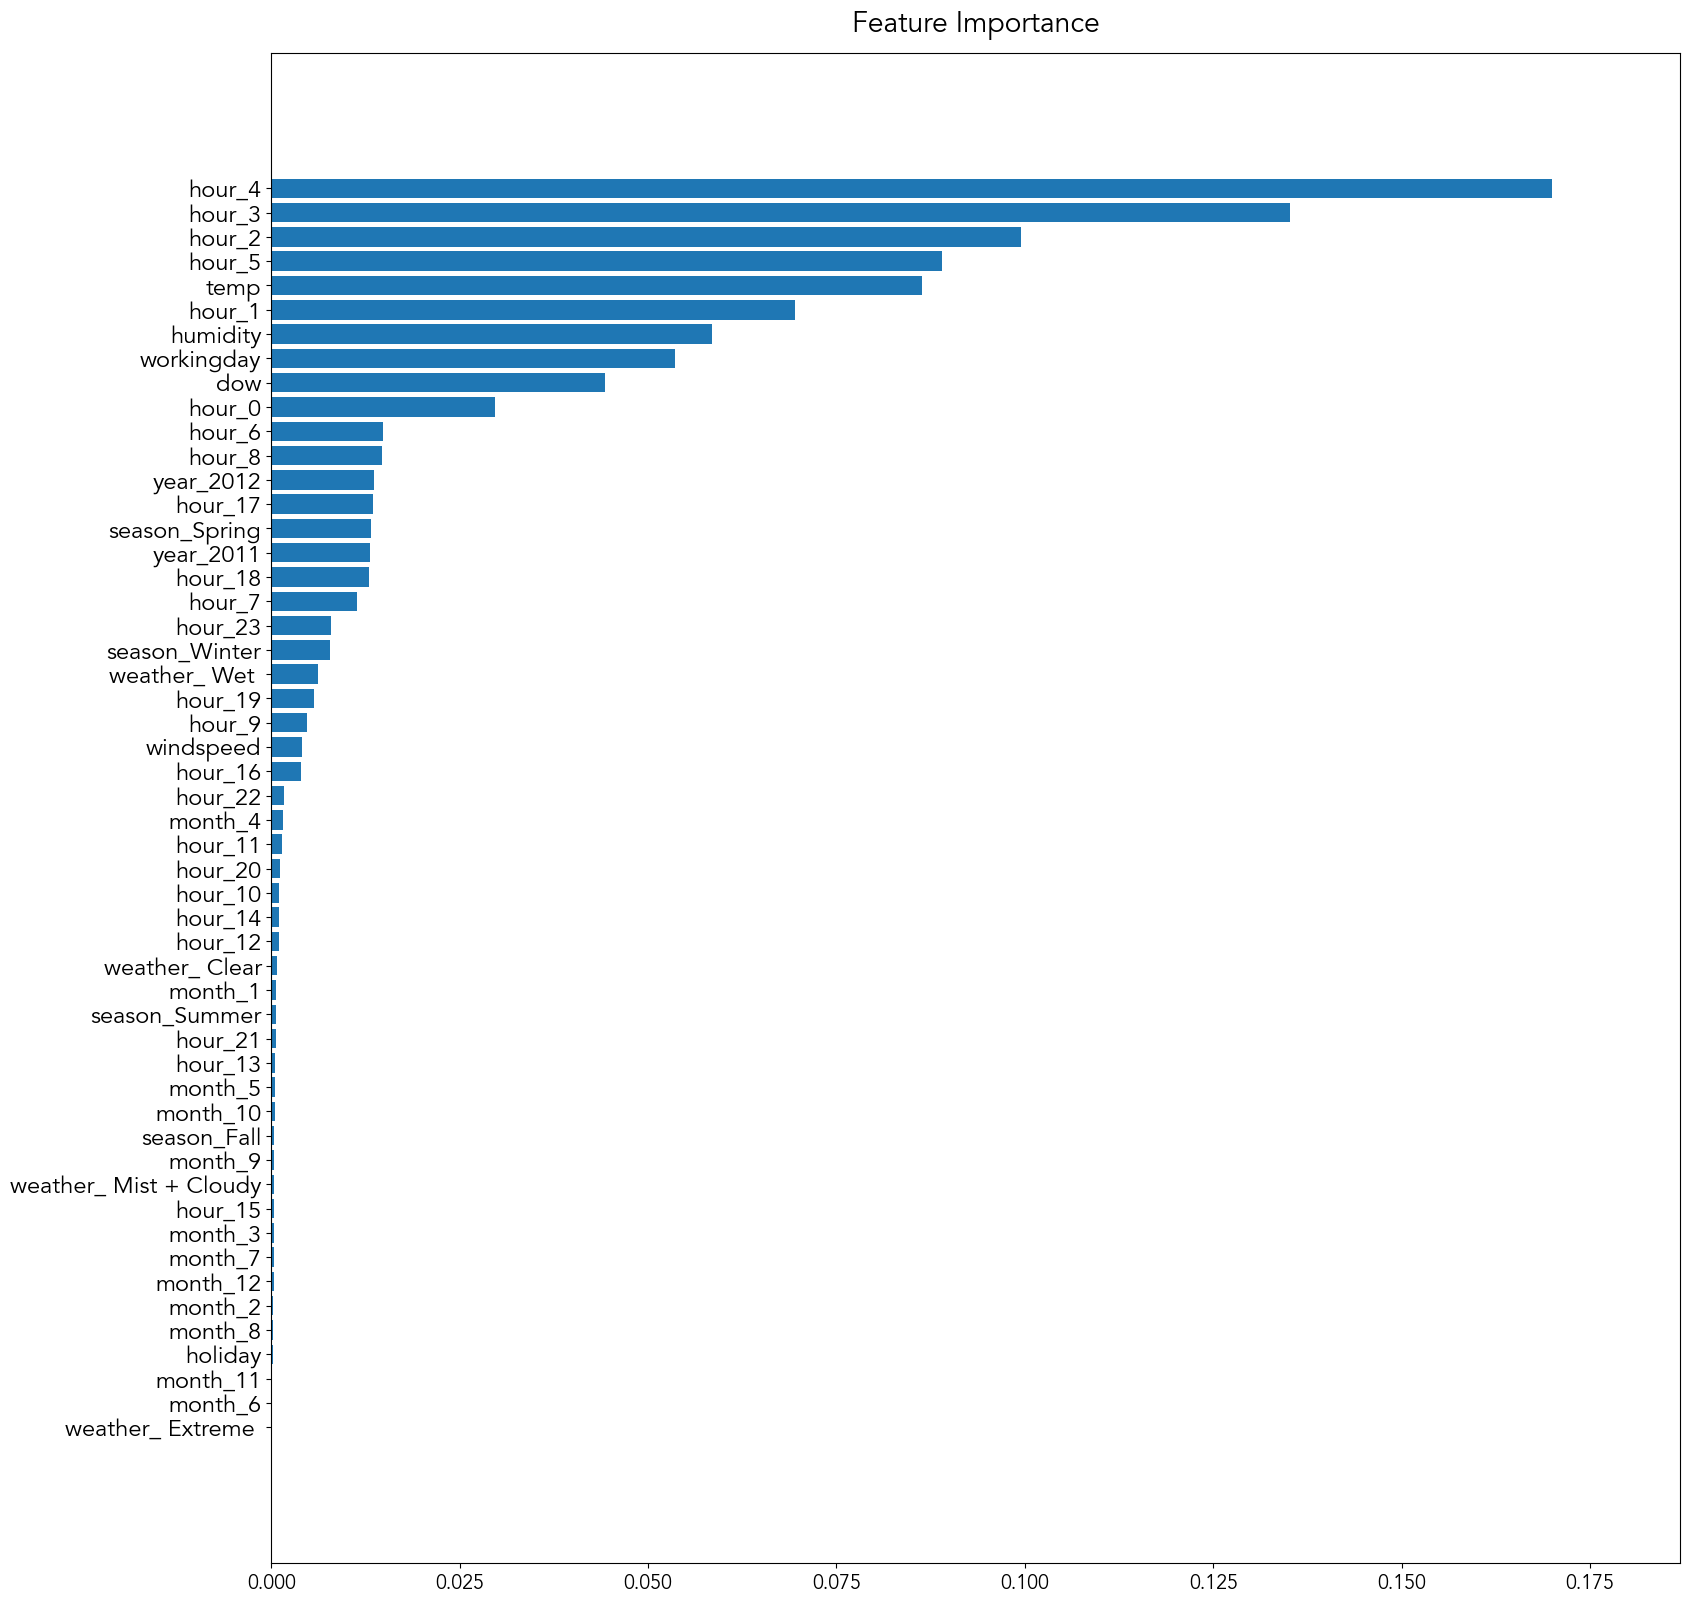

In [56]:
feature_importance = gdbr_best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(40, 20))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [65]:
from sklearn.inspection import permutation_importance
result = permutation_importance(gdbr_best_model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=None)

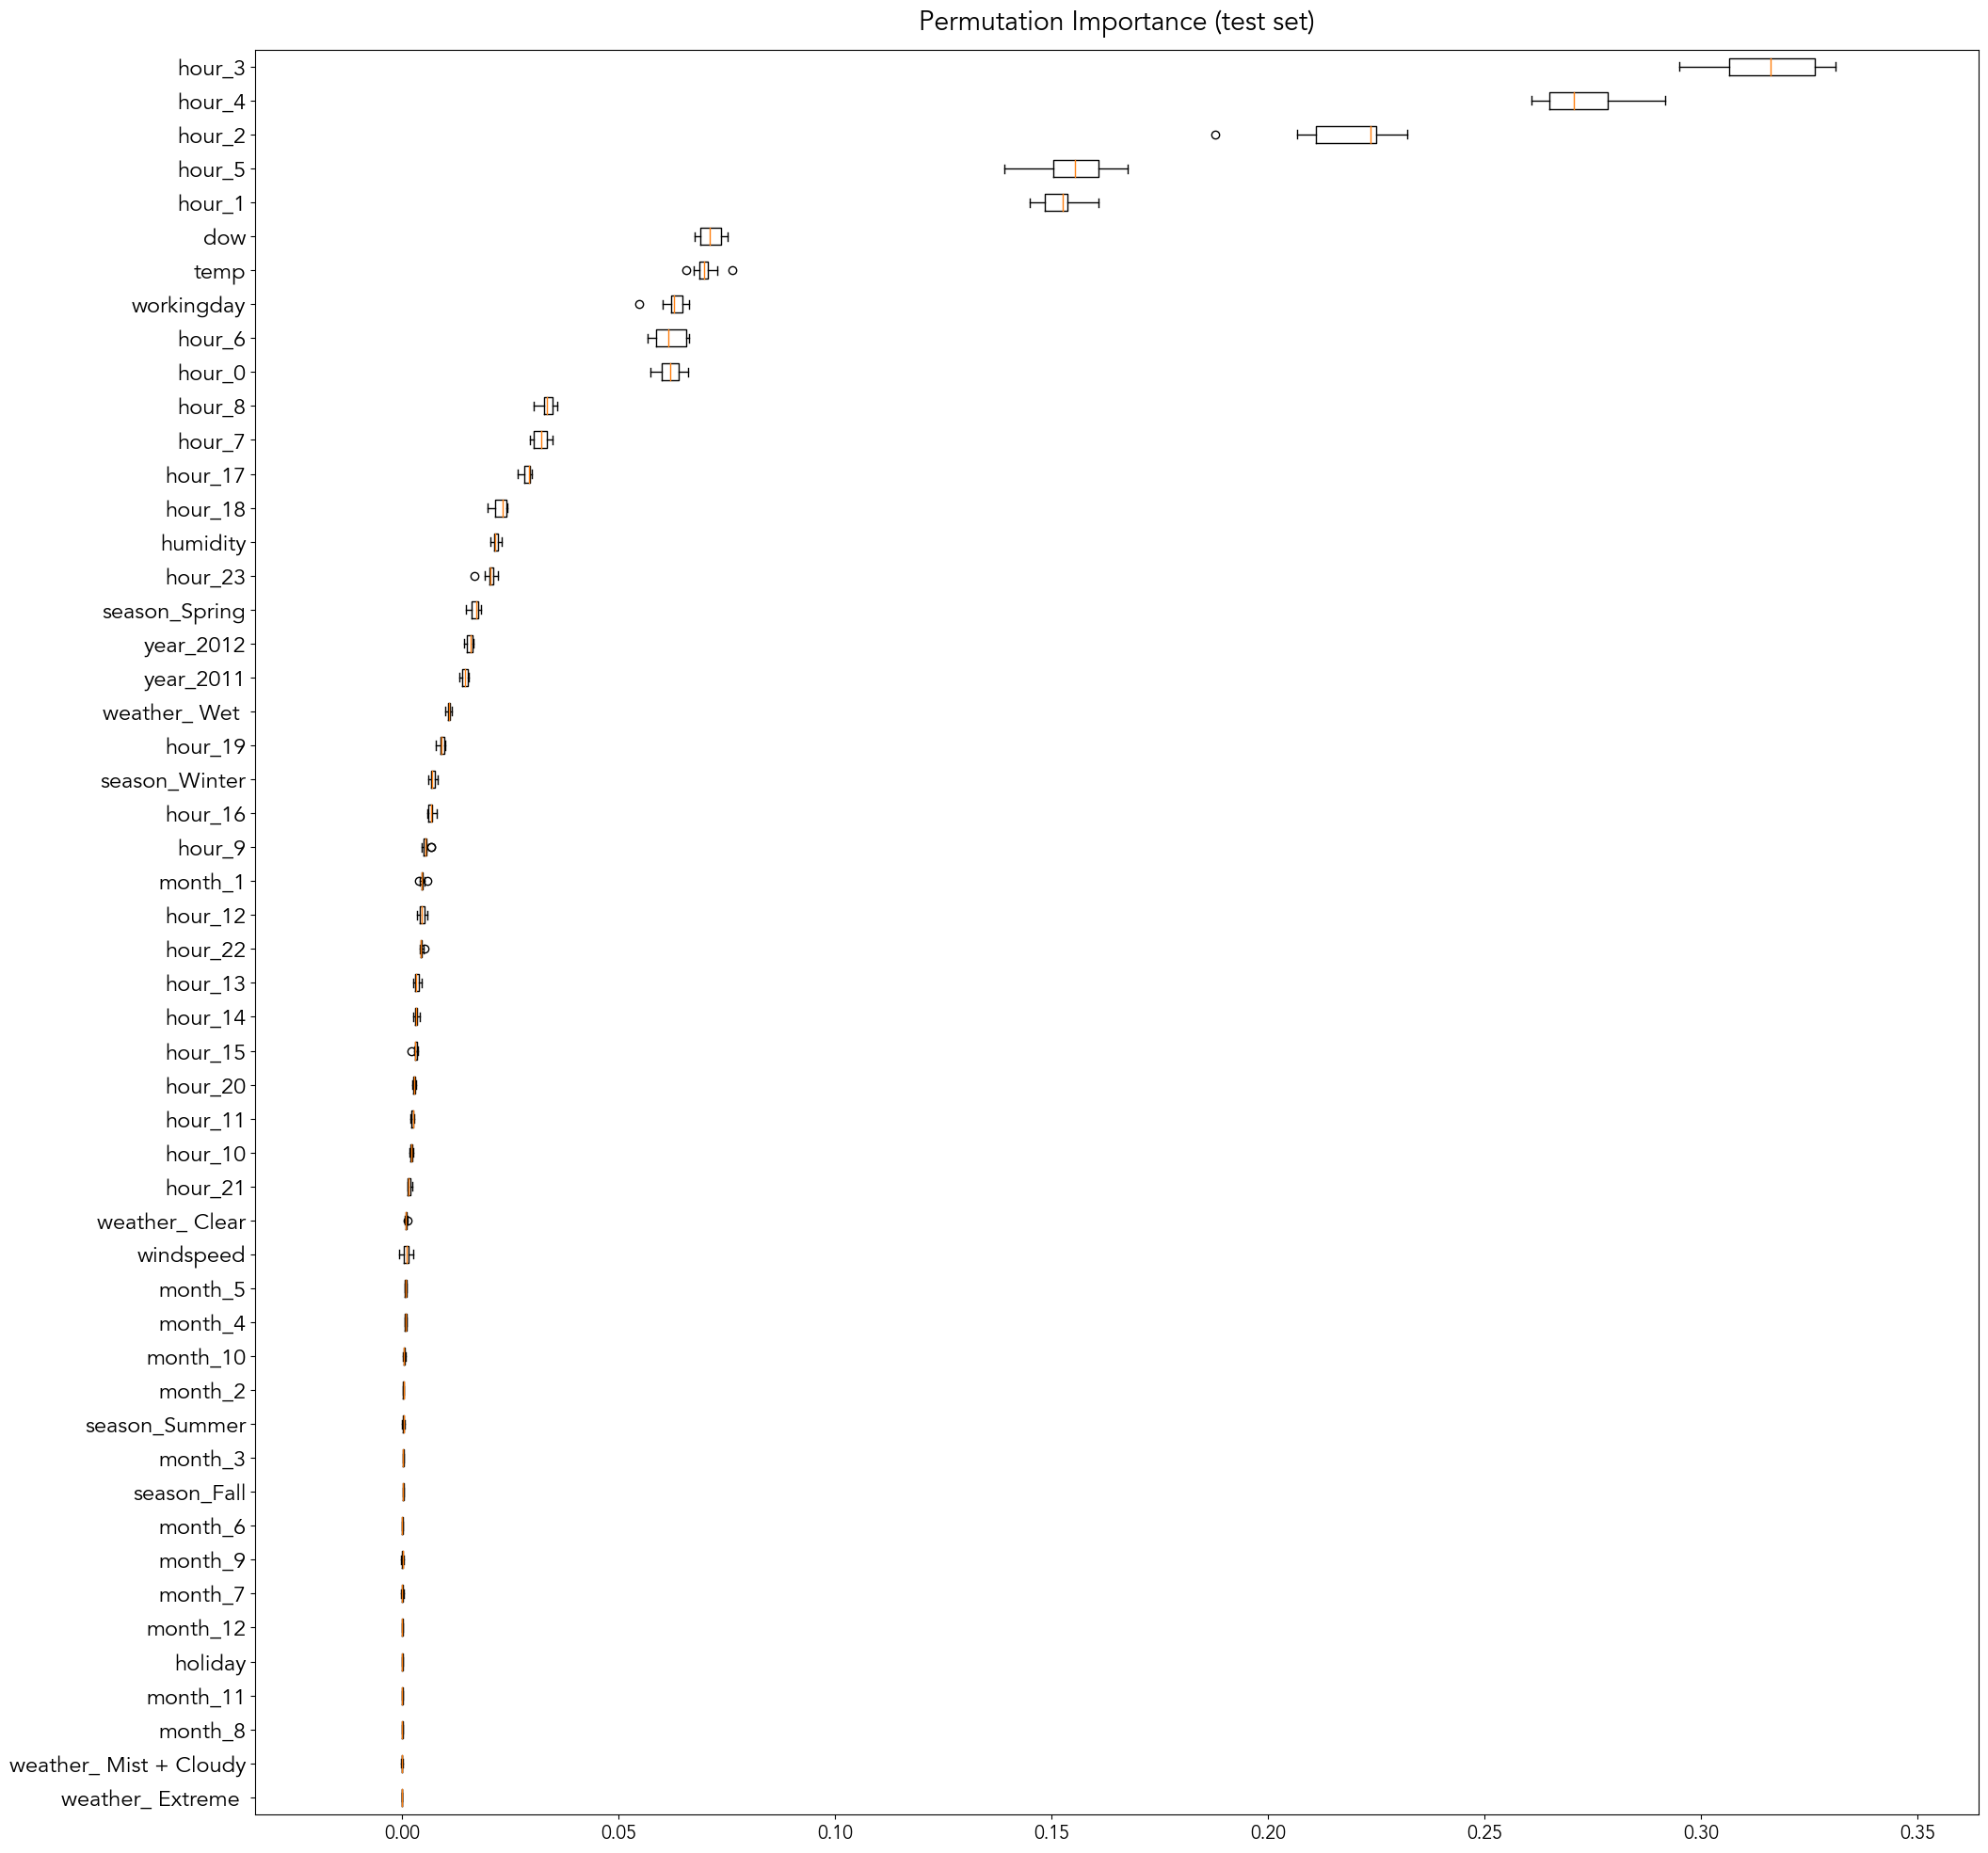

In [67]:
fig = plt.figure(figsize=(40, 20))
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## RF vs Gradient Boosting

Text(0.5, 1.0, 'Gradient Boosting vs Random Forest')

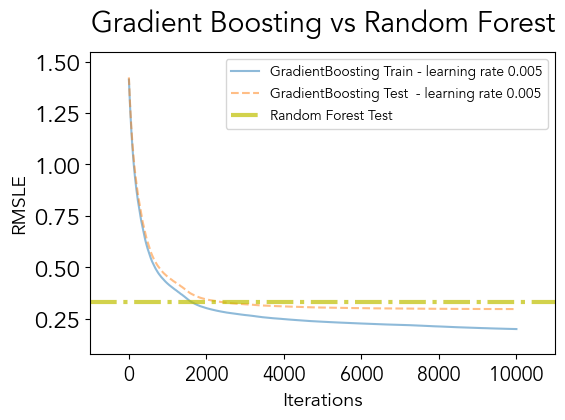

In [69]:
stage_score_plot(gdbr_best_model, X_train, y_train, X_test, y_test)
rf_score_plot(rf_best_model, X_train, y_train, X_test, y_test)
plt.legend(loc='upper right', ncol=1);
plt.title("Gradient Boosting vs Random Forest")

## Effect of learning rate (0.05 vs 0.005)

In [78]:
gdbr_lr1 = GradientBoostingRegressor(learning_rate=0.05, max_depth=6, max_features=0.1,
                          min_samples_leaf=28, n_estimators=10000,
                          random_state=1)

Text(0.5, 1.0, 'Gradient Boosting Effect of Learning Rate')

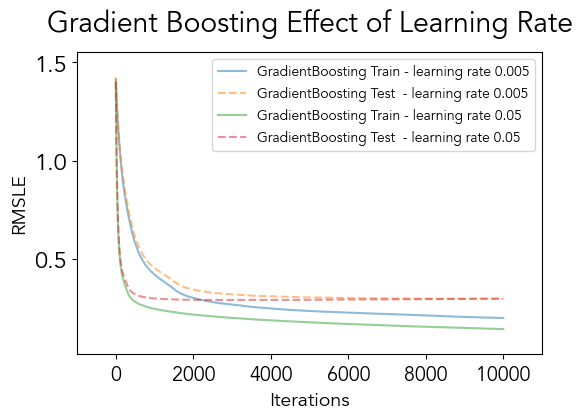

In [80]:
stage_score_plot(gdbr_best_model, X_train, y_train, X_test, y_test)
stage_score_plot(gdbr_lr1, X_train, y_train, X_test, y_test)
plt.legend(loc='upper right', ncol=1);
plt.title("Gradient Boosting Effect of Learning Rate")

## Plot of Y_actual vs Y_predicted for the best model 

In [81]:
original = pd.read_csv('train.csv')
original['time'] = pd.to_datetime(original.datetime)
original=original[['time','count']]
daily = original.resample('D', on='time').sum()
hourly = original.resample('H', on='time').mean()


predicted = pd.read_csv('best_gdbr_submission.csv')
predicted['time'] = pd.to_datetime(predicted.datetime)
predicted= predicted[['time','count']]
predicted_daily = predicted.resample('D', on='time').sum()
predicted_hourly = predicted.resample('H', on='time').mean()

combined = pd.concat([original, predicted])

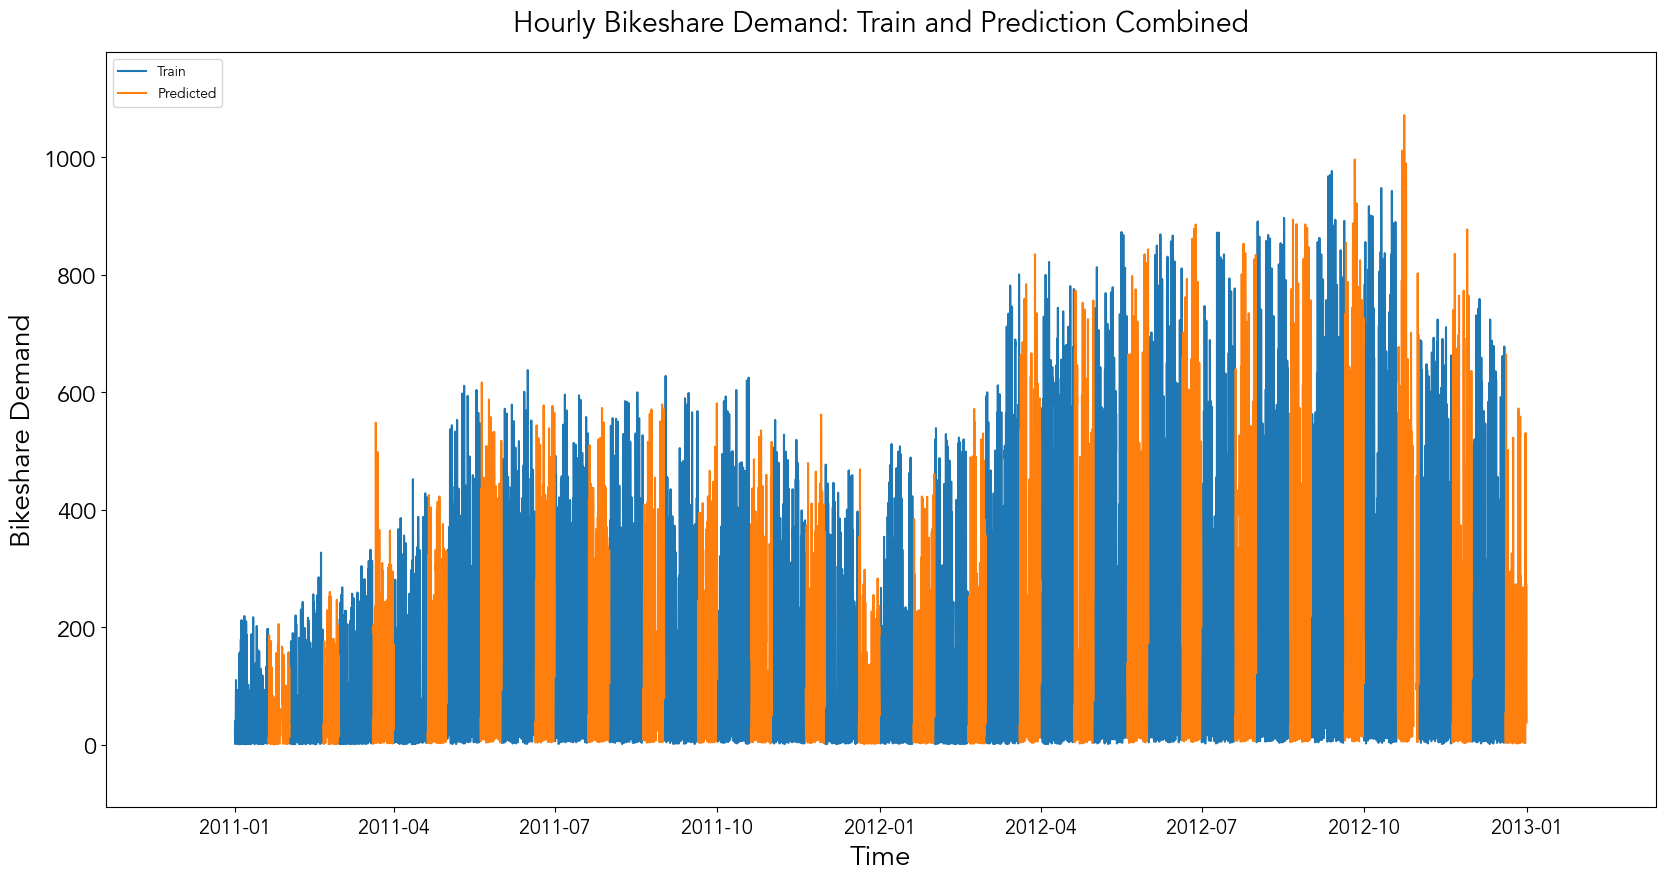

In [82]:
fig, ax = plt.subplots(figsize = (20,10))

# 1) remove points where y =0
x = np.array(hourly.reset_index()['time'])
y = np.array(hourly['count'])
y_masked = np.ma.masked_where(y == 0, y)

x2 = np.array(predicted_hourly.reset_index()['time'])
y2 = np.array(predicted_hourly['count'])
y2_masked = np.ma.masked_where(y2 == 0, y2)

plt.plot(x, y_masked, '-', label='Train')
plt.plot(x2, y2_masked, '-', label='Predicted' )
plt.legend(loc='upper left', ncol=1);
plt.ylabel('Bikeshare Demand',fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.title('Hourly Bikeshare Demand: Train and Prediction Combined')
plt.show()

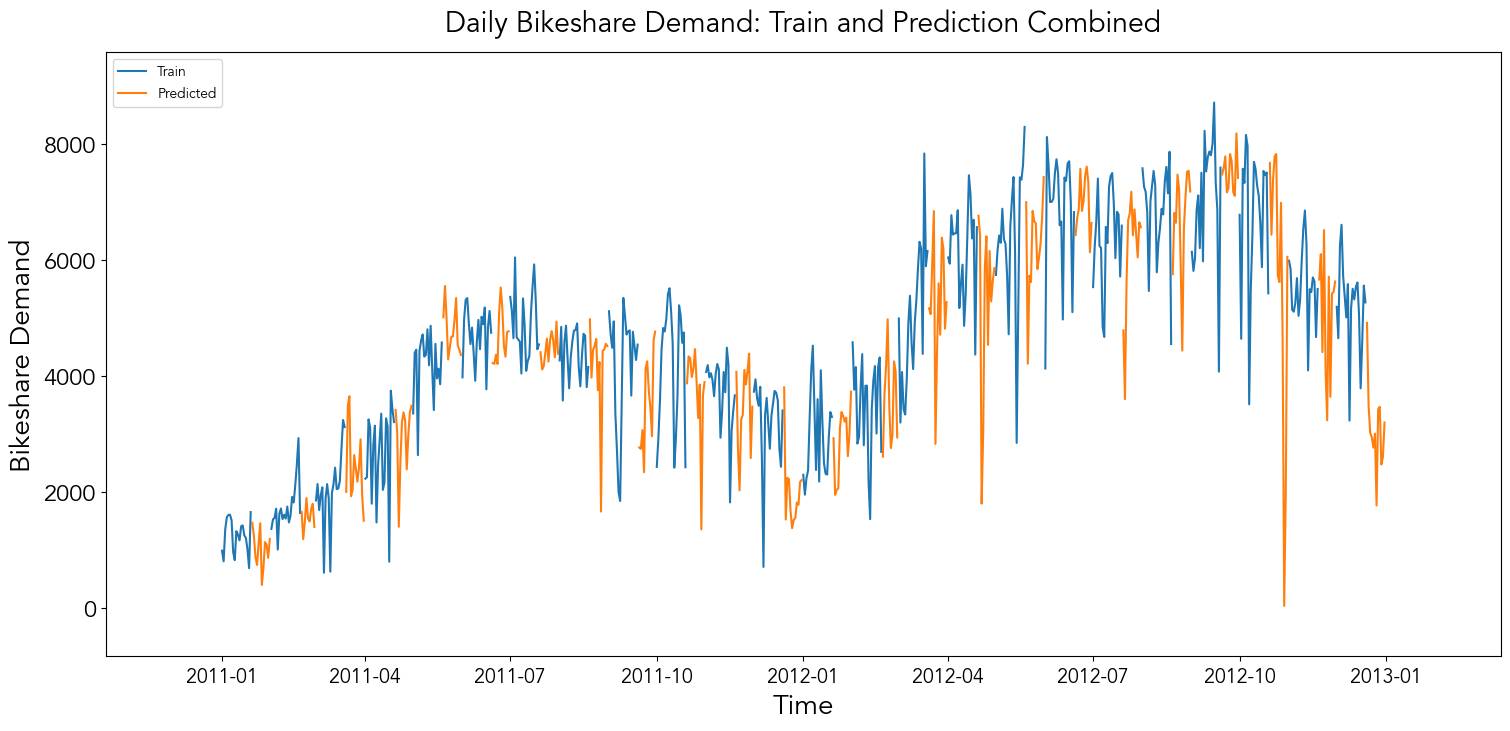

In [83]:
fig, ax = plt.subplots(figsize = (18,8))

# 1) remove points where y =0
x = np.array(daily.reset_index()['time'])
y = np.array(daily['count'])
y_masked = np.ma.masked_where(y == 0, y)

x2 = np.array(predicted_daily.reset_index()['time'])
y2 = np.array(predicted_daily['count'])
y2_masked = np.ma.masked_where(y2 == 0, y2)

plt.plot(x, y_masked, '-', label='Train')
plt.plot(x2, y2_masked, '-', label='Predicted' )
plt.legend(loc='upper left', ncol=1);
plt.ylabel('Bikeshare Demand',fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.title('Daily Bikeshare Demand: Train and Prediction Combined')
plt.show()

## Generate submission file from test.csv

In [17]:
X_real_test = test_df

In [19]:
def submission_file(model, filename):
    model.fit(X_train, y_train)
    y_real_pred = model.predict(X_real_test)
    y_real_pred = np.expm1(y_real_pred)
    submission = pd.read_csv('test.csv')
    submission['count'] = y_real_pred
    submission = submission[['datetime','count']]
    submission.to_csv(filename, index=False)

In [115]:
gdbr_best_model = GradientBoostingRegressor(learning_rate=0.005, max_depth=6, min_samples_leaf = 24, n_estimators = 10000, random_state=1)
submission_file(gdbr, 'best_GDBR.csv')